This is a cleaned up version of `retinanet-k-coco-label-function.ipynb`

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


import keras
import keras.preprocessing.image
# from keras_retinanet.preprocessing.coco import CocoGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

from PIL import Image
from keras_retinanet.utils.image import preprocess_image # <-- this is the CocoGenerator.preprocess_image() method
from keras_retinanet.utils.image import resize_image # <-- this is CocoGenerator.resize_image()

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

keras.backend.tensorflow_backend.set_session(get_session())

from keras_retinanet.models.resnet import custom_objects

model = keras.models.load_model('data/retinanet-model/resnet50_coco_best_v1.2.2.h5', 
                                custom_objects=custom_objects)

Using TensorFlow backend.
/Users/WayNoxchi/Miniconda3/envs/tfkeras/lib/python3.6/site-packages/keras/models.py:271: UserWarning: Output "non_maximum_suppression_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_1" during training.
  sample_weight_mode=sample_weight_mode)


In [10]:
# fizry/keras-retinanet/keras_retinanet/preprocessing/coco.py
# cocodataset/cocoapi/PythonAPI/pycocotools/coco.py

# Functional Implementation of COCO and CocoGenerator classes for labels
def load_classes_and_labels(data_dir='data/COCO', set_name='val2017'):
    from collections import defaultdict
    import json
    import time
    import os

    ### class COCO
    # __init__(self, annotation_file=None)
    dataset, anns, cats, imgs = dict(), dict(), dict(), dict()

    annotation_file = os.path.join(data_dir, 'annotations', 'instances_' + set_name + '.json')
    # from: class CocoGenerator.__init__: self.coco = COCO(os.path.join(data_dir, 'annotations', 'instances_' + set_name + '.json'))

    if not annotation_file == None:
        print('loading annotations...')
        tic = time.time()
        dataset = json.load(open(annotation_file, 'r'))
        assert type(dataset)==dict, f'annotation file format {type(dataset)} not supported'
        print(f'Done (t={time.time()-tic:0.2f}s)')

    # createIndex(self)
    print('creating index...')
    anns, cats, imgs = {}, {}, {}
    imgToAnns, catToImgs = defaultdict(list), defaultdict(list)
    if 'annotations' in dataset:
        for ann in dataset['annotations']:
            imgToAnns[ann['image_id']].append(ann)
            anns[ann['id']] = ann

        if 'categories' in dataset:
            for ann in dataset['annotations']:
                catToImgs[ann['category_id']].append(ann['image_id'])

    if 'images' in dataset:
        for img in dataset['images']:
            imgs[img['id']] = img

    if 'categories' in dataset:
        for cat in dataset['categories']:
            cats[cat['id']] = cat

    print('index created!')

    # getCatIDs
    catNms=[]; supNms=[]; catIds=[]     # just to preserve some semblance of the OOP method form

    catNms = catNms if _isArrayLike(catNms) else [catNms]
    supNms = supNms if _isArrayLike(supNms) else [supNms]
    catIds = catIds if _isArrayLike(catIds) else [catIds]

    if len(catNms) == len(supNms) == len(catIds) == 0:
        cats_ = dataset['categories']
    else:
        cats_ = dataset['categories']
        cats_ = cats_ if len(catNms) == 0 else [cat for cat in cats_ if cat['name']          in catNms]
        cats_ = cats_ if len(supNms) == 0 else [cat for cat in cats_ if cat['supercategory'] in supNms]
        cats_ = cats_ if len(catIds) == 0 else [cat for cat in cats_ if cat['id']            in catIds]
    ids = [cat['id'] for cat in cats_]

    # loadCats(self, ids=[])
    if _isArrayLike(ids):
        categories = [cats[id] for id in ids]
    elif type(ids) == int:
        categories = [cats[ids]]

    ### class CocoGenerator(Generator)
    # __init__(self, data_dir, set_name, image_data_generator, *args, **kwargs)
    # load_classes(self)
    categories.sort(key=lambda x: x['id'])

    classes             = {}
    coco_labels         = {}
    coco_labels_inverse = {}
    for c in categories:
        coco_labels[len(classes)] = c['id']
        coco_labels_inverse[c['id']] = len(classes)
        classes[c['name']] = len(classes)

    labels = {}
    for key, value in classes.items():
        labels[value] = key

    return classes, labels

def _isArrayLike(obj):
    return hasattr(obj, '__iter__') and hasattr(obj, '__len__')

# name_to_label(self,name)
def name_to_label(name, classes):
    return classes[name]

# label_to_name(self, label)
def label_to_name(label, labels):
    return labels[label]

# classes, labels = load_classes_and_labels()

In [36]:
def detect_one(image=None, threshold=0.5, mode=1, COCO_Label=False):
    if COCO_Label:
        classes, labels = load_classes_and_labels()
    
    # copy image to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    # process image
    start = time.time()
    _,_, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)
    
    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
    
    label = predicted_labels[0]
    label_name = label_to_name(label, labels) if COCO_Label else label
    
    # correct for image scale
    detections[0, :, :4] /= scale
    
    # visualize detections
#     count = 0
#     max_score = -1
    
    caption = ""
    # pull out the most confident predicted label
    b = detections[0, np.argmax(scores), :4].astype(int)
#     return b

    # draw the bounding box & label+score on the image
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,0,255), 3)
    caption = f'Pilot "{label_name}" {scores[np.argmax(scores)]:.3f}'
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1., (0,0,0), 4, cv2.LINE_AA)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1., (255,255,255), 2, cv2.LINE_AA)
    
    if mode == 1:
        # print next 4 top labels
        for idx, (label, score) in enumerate(zip(predicted_labels[1:5], scores[1:5])):
            label_name = str(label)+':'+label_to_name(label, labels) if COCO_Label else label
            
            # get bounding box
            b = detections[0, idx, :4].astype(int)
            # draw the bounding box & label+score on the image
            cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0,255,0), 2)
            caption = f'`{label_name}` {scores[np.argmax(scores)]:.3f}'
            cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 3, cv2.LINE_4)
            cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 1, cv2.LINE_4)

    for idx, (label,score) in enumerate(zip(predicted_labels[:5], scores[:5])):
        name = label_to_name(label, labels) if COCO_Label else label
        bb = detections[0,idx, :4].astype(int)
        print(f'{label}:{name}: {score} -- {bb}')
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    
def detect_pilot(trainpath = 'data/train/', folder="", threshold=0.5, mode=0, COCO_Label=False):
    if folder == "":
        print("No folder specified")
        return

    fpaths = [trainpath + folder + '/' + fname for fname in os.listdir(trainpath + folder)]

    idx = np.random.choice(np.arange(len(fpaths)))
    print(f'Image path: {fpaths[idx]}')

    image = fpaths[idx]

    image = Image.open(image)
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    
    detect_one(image, threshold=threshold, mode=mode, COCO_Label=COCO_Label)

In [4]:
trainpath = 'data/train/'
folders = os.listdir(trainpath)

Image path: data/train/006440-006548/006530.jpg
loading annotations...
Done (t=0.70s)
creating index...
index created!
processing time:  5.382027864456177
person: 0.23614585399627686 -- [217  -1 394 370]
person: 0.2081797868013382 -- [ 23  23 269 383]
person: 0.16579367220401764 -- [161  -5 283 310]
person: 0.09263131022453308 -- [  7  53 168 306]
person: 0.09214271605014801 -- [304   1 399 248]


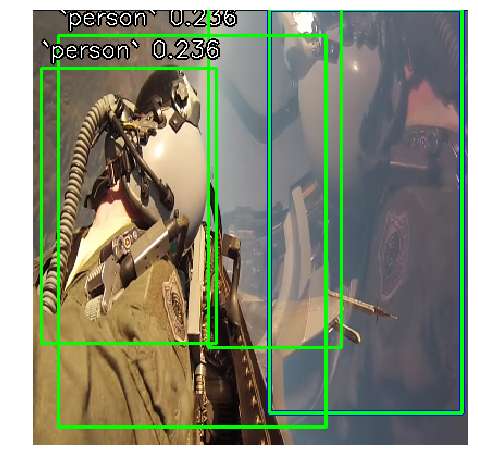

In [14]:
detect_pilot(folder = np.random.choice(folders), mode=1, COCO_Label=True)

processing time:  5.952758073806763
0: 0.23614585399627686 -- [217  -1 394 370]
0: 0.2081797868013382 -- [ 23  23 269 383]
0: 0.16579367220401764 -- [161  -5 283 310]
0: 0.09263131022453308 -- [  7  53 168 306]
0: 0.09214271605014801 -- [304   1 399 248]


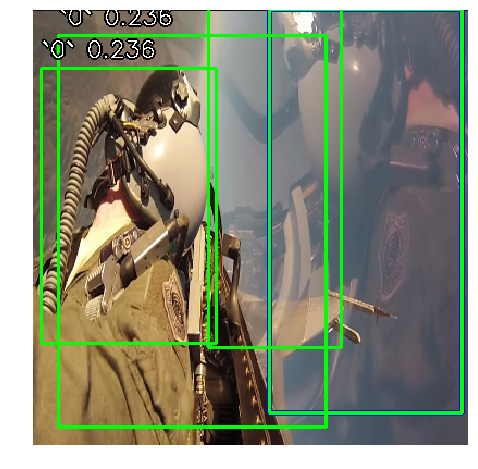

In [15]:
detect_one(image=cv2.cvtColor(np.array(Image.open('data/train/006440-006548/006530.jpg')), 
                              cv2.COLOR_RGB2BGR),
           mode=1,
           COCO_Label=False)

Image path: data/train/006440-006548/006459.jpg
loading annotations...
Done (t=0.52s)
creating index...
index created!
processing time:  5.436061143875122
truck: 0.14194853603839874 -- [  3  93 197 395]
umbrella: 0.11519493907690048 -- [ 80 192 174 391]
backpack: 0.08195500075817108 -- [  1  96  67 224]
person: 0.07087025046348572 -- [ -1 101  83 379]
tie: 0.06128609925508499 -- [156 266 193 397]


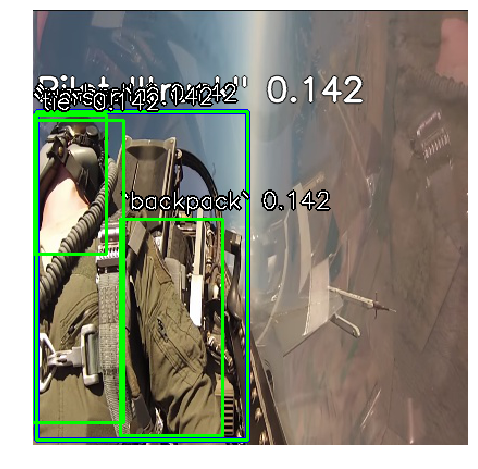

In [16]:
detect_pilot(folder = np.random.choice(folders), mode=1, COCO_Label=True)

Image path: data/train/001190-001434/001305.jpg
loading annotations...
Done (t=0.73s)
creating index...
index created!
processing time:  5.868336915969849
17:horse: 0.409955233335495 -- [ 58  36 311 359]
75:vase: 0.3257748484611511 -- [ 33 276  81 362]
75:vase: 0.11611246317625046 -- [ 65 276 115 357]
14:bird: 0.10720420628786087 -- [102  53 235 250]
39:bottle: 0.08806125074625015 -- [ 34 280  55 357]


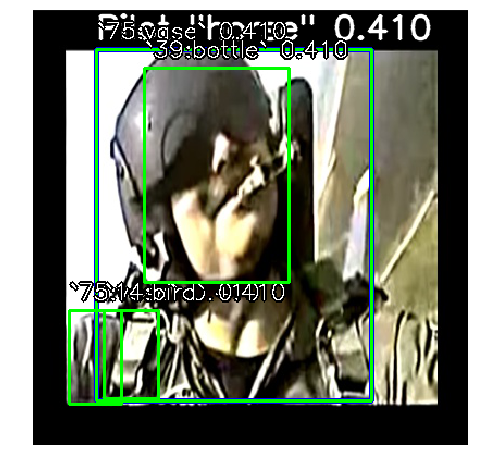

In [20]:
detect_pilot(folder = np.random.choice(folders), mode=1, COCO_Label=True)

Image path: data/train/006440-006548/006498.jpg
loading annotations...
Done (t=0.67s)
creating index...
index created!
processing time:  5.432374000549316
0:person: 0.186538964509964 -- [  5  71 200 388]
0:person: 0.18638744950294495 -- [254   9 337 173]
0:person: 0.12811142206192017 -- [300   7 357 147]
0:person: 0.11754848808050156 -- [313   4 391 183]
0:person: 0.11156096309423447 -- [238   4 306 107]


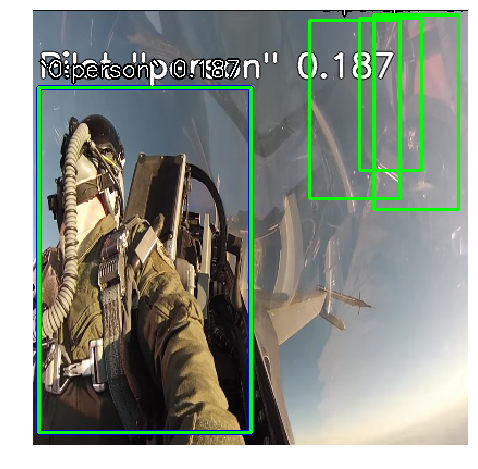

In [21]:
detect_pilot(folder = np.random.choice(folders), mode=1, COCO_Label=True)

Image path: data/train/006440-006548/006488.jpg
loading annotations...
Done (t=0.51s)
creating index...
index created!
processing time:  5.353989124298096
4:airplane: 0.48051655292510986 -- [265 254 315 275]
24:backpack: 0.3530902564525604 -- [  1  33 111 396]
3:motorcycle: 0.1311909407377243 -- [ 15  19 233 392]
0:person: 0.11189157515764236 -- [  2  51  49 172]
26:handbag: 0.11154604703187943 -- [109 302 193 396]


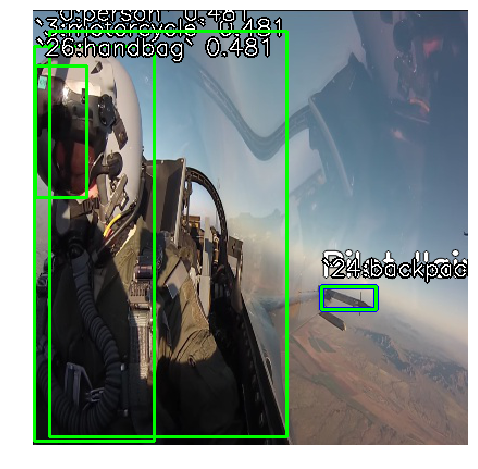

In [22]:
detect_pilot(folder = np.random.choice(folders), mode=1, COCO_Label=True)

Image path: data/train/001435-001882/001470.jpg
loading annotations...
Done (t=0.50s)
creating index...
index created!
processing time:  5.328753232955933
31:snowboard: 0.4345985949039459 -- [163  66 310 341]
31:snowboard: 0.11708565056324005 -- [155 114 227 336]
24:backpack: 0.07439909130334854 -- [ 48  44 384 374]
2:car: 0.049793172627687454 -- [ 40  98 223 341]
33:kite: 0.04463643953204155 -- [202 107 289 289]


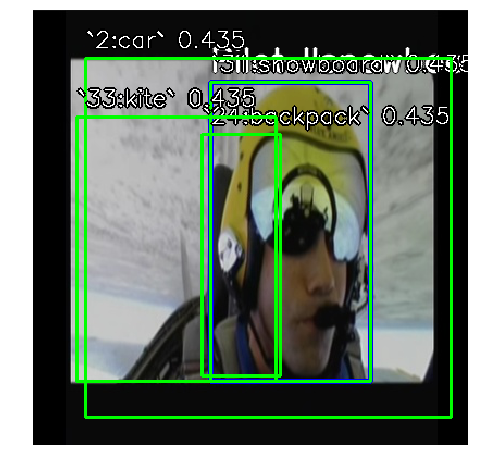

In [23]:
detect_pilot(folder = np.random.choice(folders), mode=1, COCO_Label=True)

Image path: data/train/006242-006439/006379.jpg
loading annotations...
Done (t=0.65s)
creating index...
index created!
processing time:  5.47140097618103
0:person: 0.649036705493927 -- [  0  23 122 392]
37:surfboard: 0.5100215673446655 -- [287  48 358 205]
24:backpack: 0.23524558544158936 -- [ 28 287 112 394]
24:backpack: 0.17872749269008636 -- [  5  43  90 251]
31:snowboard: 0.17344267666339874 -- [ 83  68 223 389]


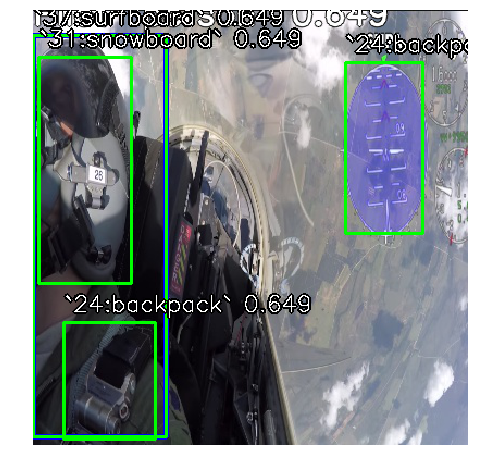

In [24]:
detect_pilot(folder = np.random.choice(folders), mode=1, COCO_Label=True)

Image path: data/train/003604-003904/003788.jpg
loading annotations...
Done (t=0.68s)
creating index...
index created!
processing time:  5.3379669189453125
0:person: 0.8347153663635254 -- [106  66 266 396]
24:backpack: 0.07214250415563583 -- [109 237 149 382]
26:handbag: 0.07178717106580734 -- [228 247 283 399]
26:handbag: 0.06638694554567337 -- [228 356 278 398]
74:clock: 0.04649706184864044 -- [184 237 232 258]


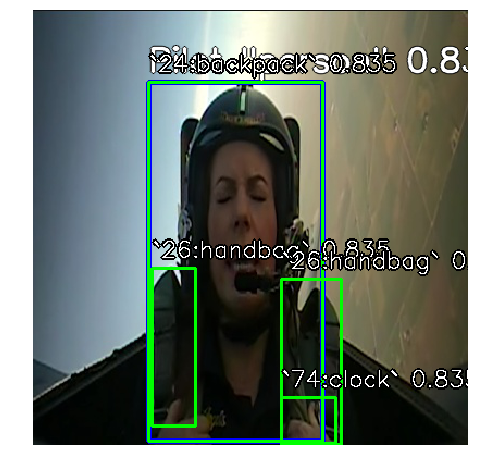

In [25]:
detect_pilot(folder = np.random.choice(folders), mode=1, COCO_Label=True)

Alright that's good. Now on to the next stage. Now to write the program for Semi-Supervised intermediate cropped image generation. Mouthful. The thing that autocrops the pilot, but to first train it. Here we go!

`Wayne Nixalo -- 19:58 02-Jan 2018`

In [34]:
image=cv2.cvtColor(np.array(Image.open('data/train/006440-006548/006530.jpg')), 
                              cv2.COLOR_RGB2BGR)
image = preprocess_image(image)
image, _ = resize_image(image)

_,_, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
# _,_, detections = model.predict(np.expand_dims(image, axis=0))

predicted_labels = np.argmax(detections[0,:,4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

In [35]:
predicted_labels[:20]

array([ 0,  0,  0,  0,  0,  4,  1,  0,  0,  0, 74, 67,  0,  0,  0,  0, 26,
       28,  0, 26])

In [33]:
predicted_labels[:20]

array([ 0,  0,  0,  0,  0,  4,  1,  0,  0,  0, 74, 67,  0,  0,  0,  0, 26,
       28,  0, 26])

Some testing on the bounding boxes.

In [43]:
b = detect_one(image=cv2.cvtColor(np.array(Image.open('data/train/006440-006548/006530.jpg')), 
                              cv2.COLOR_RGB2BGR),
           mode=1,
           COCO_Label=False)

processing time:  5.810520887374878


In [44]:
b

array([217,  -1, 394, 370])

In [49]:
for i,e in b:
    b[i] = max(0,e)

TypeError: 'numpy.int64' object is not iterable

Whaaaat.. Do we really need 64-bit Integers for a set of bounding-box coordinates?

In [50]:
for i in range(len(b)):
    b[i] = max(0, b[i])
b

array([217,   0, 394, 370])

In [51]:
type(b)

numpy.ndarray

In [52]:
type(None)

NoneType

In [42]:
b

[217, 0, 394, 370]